# WASP-103b: custom LC detrend function

## Data Analysis

In [1]:
import numpy as np
import CONAN
import matplotlib.pyplot as plt

CONAN.__version__


'3.3.12'

In [2]:
from CONAN.get_files import get_parameters
P          = 0.925545485
BJD_0      =  2457511.944458 -2457000
sys_params = get_parameters("WASP-103")
path       = "data/"


Loading parameters from cache ...


In order to derive different occultation depths for the observations, we will set different filters

Rescaled data columns of WASP-103_000905.dat with method:med_sub


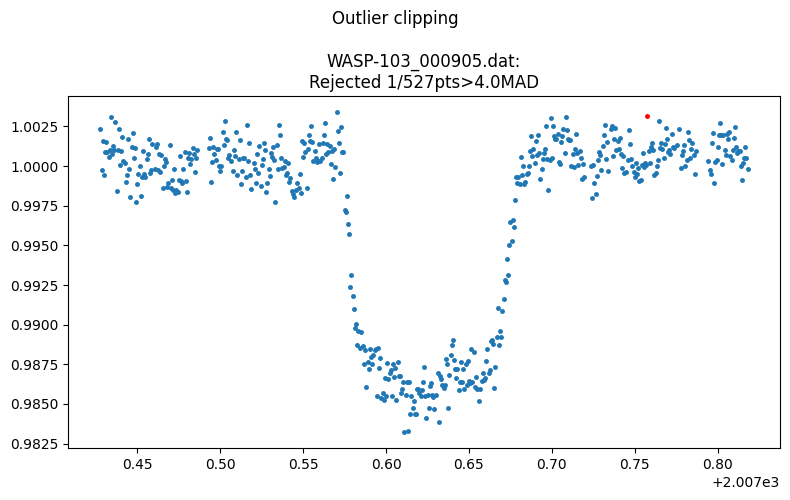

In [3]:
lc_obj = CONAN.load_lightcurves(
                                file_list       = 'WASP-103_000905.dat', 
                                data_filepath   = path, 
                                filters         = "CH",
                                wl              = 0.6)

lc_obj.rescale_data_columns(verbose=True)
lc_obj.clip_outliers(   width=15, 
                        clip=4,     
                        niter =1,
                        show_plot=True,
                        verbose=False)

In [4]:
q1 = (0.4287, 0.0666)
q2 = (0.4023, 0.0284)

In [5]:
t14 = sys_params['planet']['T14'][0]
tra_occ_pars =dict( T_0         = (BJD_0-0.1,BJD_0,BJD_0+0.1),      
                    Period      = (P,5e-8),          
                    Impact_para = (0,0.1,1),      
                    RpRs        = (0.09,0.113,0.13), 
                    Duration    = (0.8*t14, t14, 1.2*t14))
tra_occ_pars

{'T_0': (511.84445799989624, 511.94445799989626, 512.0444579998963),
 'Period': (0.925545485, 5e-08),
 'Impact_para': (0, 0.1, 1),
 'RpRs': (0.09, 0.113, 0.13),
 'Duration': (0.08643333333333333, 0.10804166666666666, 0.12965)}

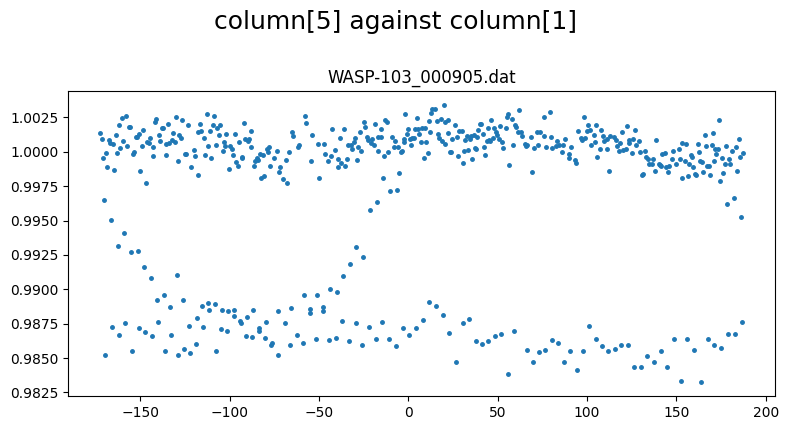

In [6]:
lc_obj.plot((5,1))

### define custom function to model roll angle

Note that there are several other ways to model CHEOPS roll-angle variations in CONAN, including using spline, sinusoids, or Gaussian Processes. 

We reimplement the sinusoidal model as a custom function here

In [7]:
def fourier_model(roll, S1, C1, S2, C2, S3, C3, extra_args=dict(unit='ppm')):
    """ 
    A custom detrending function that models the baseline flux variations as a Fourier series up to the second harmonic
    with S1, S2, S3 being the amplitudes of the sin terms and C1, C2, C3 those for the cosine terms.

    extra_args can be used to pass additional parameters (non-varying), such as the desired output unit.
    """
    import numpy as np
    ppm = 1e-6
    roll_radians = np.deg2rad(roll)
    roll_model = S1 * np.sin(roll_radians)   + C1 * np.cos(roll_radians) + \
                 S2 * np.sin(2*roll_radians) + C2 * np.cos(2*roll_radians) + \
                 S3 * np.sin(3*roll_radians) + C3 * np.cos(3*roll_radians)

    if extra_args.get('unit') == 'ppm':
        return roll_model * ppm
    else:
        return roll_model
    
def op_func(transit_model, custom_model):   # operation function to combine the custom model with the transit model
    return transit_model + custom_model

In [8]:

cfunc = lc_obj.add_custom_LC_function(  func       = fourier_model,
                                        x          = 'col5',    
                                        func_args  = dict(  S1=(-700,0,700),   #priors
                                                            C1=(-700,0,700),   #priors
                                                            S2=(-700,0,700),   #priors
                                                            C2=(-700,0,700),   #priors
                                                            S3=(-700,0,700),   #priors
                                                            C3=(-700,0,700)),  #priors
                                        extra_args = dict(unit='ppm'),  # non-varying input to func
                                        op_func    = op_func
                                        )

# ============ Custom LC function (read from custom_LCfunc.py file)================================================
function        : fourier_model                           	#custom function/class to combine with/replace LCmodel
x               : col5                                    	#independent variable [time, phase_angle]
func_pars       : S1:U(-700,0,700),C1:U(-700,0,700),S2:U(-700,0,700),C2:U(-700,0,700),S3:U(-700,0,700),C3:U(-700,0,700)	#param names&priors e.g. A:U(0,1,2),P:N(2,1)
extra_args      : unit:ppm                                	#extra args to func as a dict e.g ld_law:quad
op_func         : op_func                                 	#function to combine the LC and custom models
replace_LCmodel : False                                   	#if the custom function replaces the LC model


### Least squares fit

Let's do a least squares fit with this setup 

setting custom LC function from saved object attribute

getting decorr params for lc01: WASP-103_000905.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:715.27, pars:['offset', 'A0']

Setting-up parametric baseline model from decorr result
# ============ Input lightcurves, filters baseline function =======================================================
name                flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-103_000905.dat CH  0.6  |None c1:W15C4n1   med_sub |  y    1    0    0    0    0    0    0|n    1 n  None           
Total number of baseline parameters: 2

Setting-up transit pars from input values
# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
rho_star/[Duration]        y   	U(0.08643333333333333,0.10804166666666666,0.12965)	#choice in []|unit

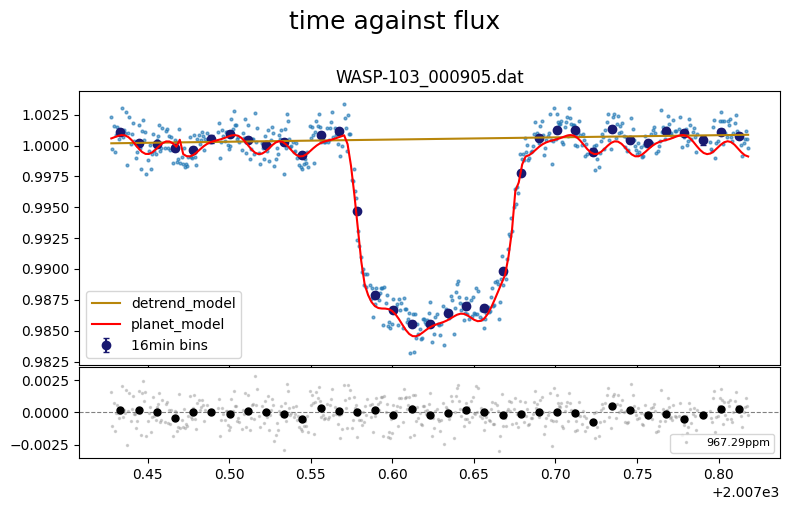

In [9]:
decorr_res = lc_obj.get_decorr( 
                                **tra_occ_pars, 
                                q1              = q1,
                                q2              = q2,
                                delta_BIC       = -5, 
                                exclude_cols    = [5], 
                                setup_planet    = True,
                                show_steps      = False,
                                use_jitter_est  = False,
                                cont            = 0.092,
                                # custom_LCfunc   = cfunc     #include the custom func in LS fit
                                )

In [10]:
decorr_res[0]

Let's plot the residual of this least-square fit

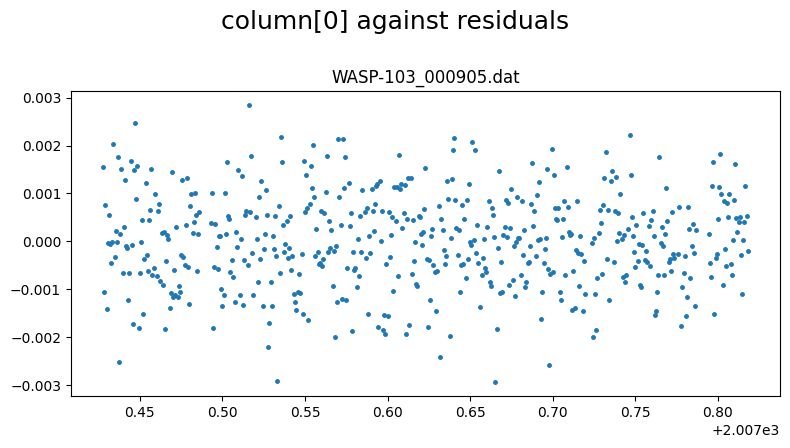

In [11]:
lc_obj.plot((0,"res"), show_decorr_model=True)

### setup fit

In [12]:
fit_obj = CONAN.fit_setup(  R_st = sys_params["star"]["radius"], 
                            M_st = sys_params["star"]["mass"], 
                            apply_LCjitter = "y")

fit_obj.sampling(sampler="dynesty",n_cpus=10,n_live=300)

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.436,0.052)
Mass_[Msun]    N(1.22,0.039)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho
# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    300 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])   

### Save and load config file

In [13]:
CONAN.create_configfile(lc_obj,None,fit_obj,filename="WASP103_CHEOPS_custom_func.dat", verify=True)

configuration file saved as WASP103_CHEOPS_custom_func.dat
_input_lc                : False

lc_obj loaded from this config file is not equal to original lc_obj
configuration file saved as WASP103_CHEOPS_custom_func.yaml
_input_lc                : False

lc_obj loaded from this config file is not equal to original lc_obj


In [37]:
import CONAN
lc_obj, rv_obj, fit_obj = CONAN.load_configfile("WASP103_CHEOPS_custom_func.yaml")

In [14]:
CONAN.get_parameter_names(lc_obj,None,fit_obj)[1]

{'Duration': 'U(0.08643333333333333,0.10804166666666666,0.12965)',
 'T_0': 'U(511.84445799989624,511.94445799989626,512.0444579998963)',
 'RpRs': 'U(0.09,0.113,0.13)',
 'Impact_para': 'U(0,0.1,1)',
 'Period': 'N(0.925545485,5e-08)',
 'CH_q1': 'N(0.4287,0.0666)',
 'CH_q2': 'N(0.4023,0.0284)',
 'lc1_logjitter': 'U(-15.0000,-8.2327,-4.7216)',
 'S1': 'U(-700,0,700)',
 'C1': 'U(-700,0,700)',
 'S2': 'U(-700,0,700)',
 'C2': 'U(-700,0,700)',
 'S3': 'U(-700,0,700)',
 'C3': 'U(-700,0,700)',
 'lc1_off': 'U(0.98322302,1,1.00338933)',
 'lc1_A0': 'U(-1,0,1)'}

### Run  fit

In [ ]:
result = CONAN.run_fit(lc_obj, None, fit_obj, 
                        out_folder="result_WASP103_CHEOPS_custom_func",
                        rerun_result=True
                        )

### load result

In [1]:
import CONAN
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

result = CONAN.load_result("result_WASP103_CHEOPS_custom_func")


['lc'] Output files, ['WASP-103_000905_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, [], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.


We can check if there are still any correlations between the residuals and the cotrending vectors

setting custom LC function from saved object attribute

getting decorr params for lc01: WASP-103_000905.dat (spline=False, sine=False, gp=False, s_samp=False, jitt=0.0ppm)
BEST BIC:572.37, pars:['offset']

Setting-up parametric baseline model from decorr result
# ============ Input lightcurves, filters baseline function =======================================================
name                flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
WASP-103_000905.dat CH  0.6  |None None         None    |  y    0    0    0    0    0    0    0|n    1 n  None           
Total number of baseline parameters: 1


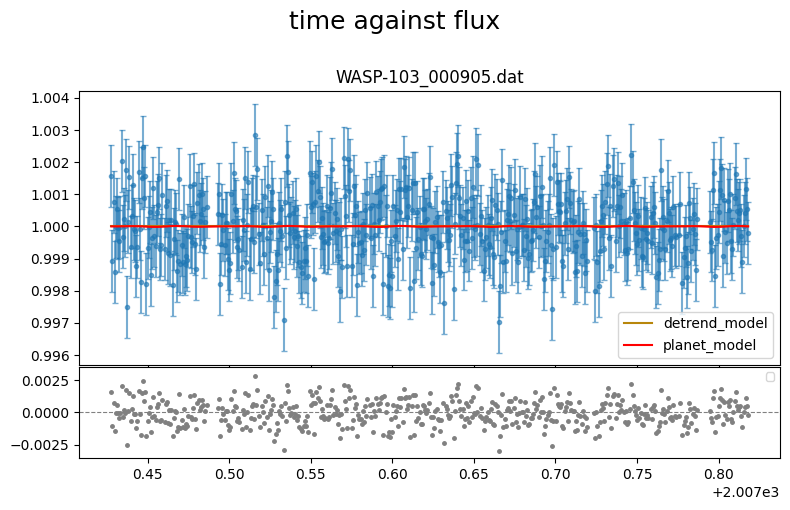

In [16]:
res_corr = result.lc.check_corr()

There are no significant correlations left in the residuals

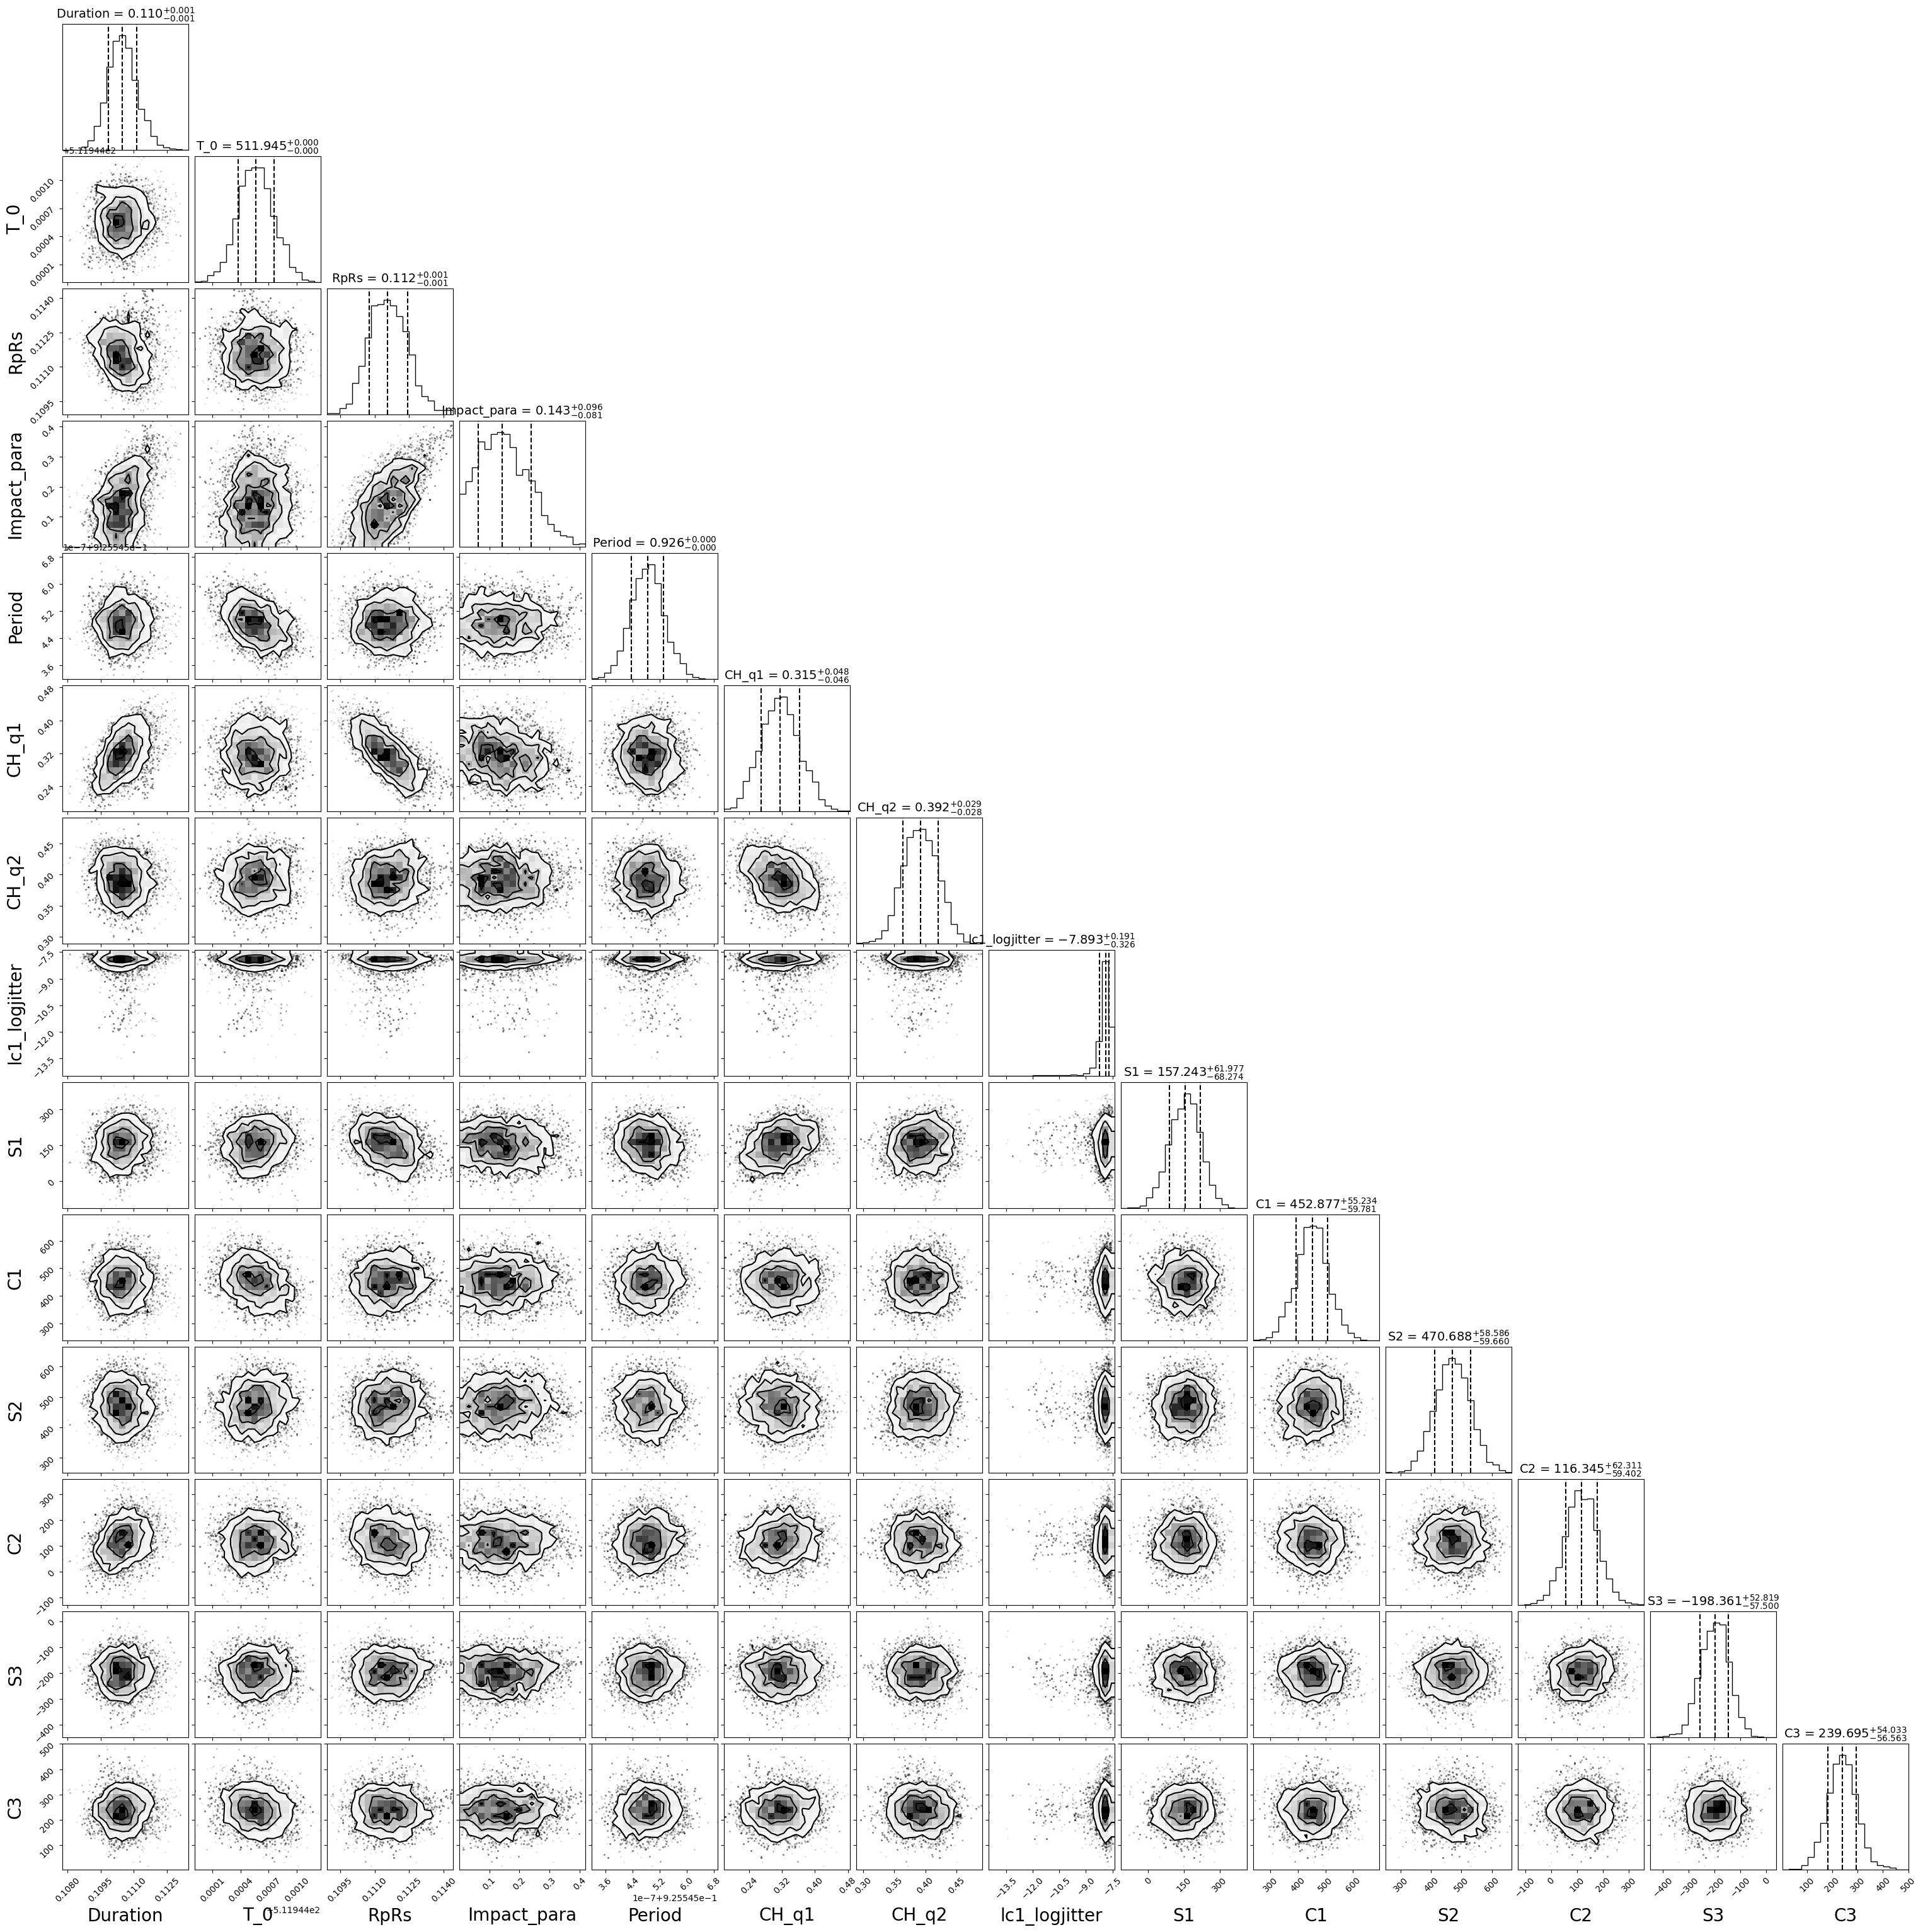

In [17]:
result.plot_corner(pars = result.params.names[:-2]);

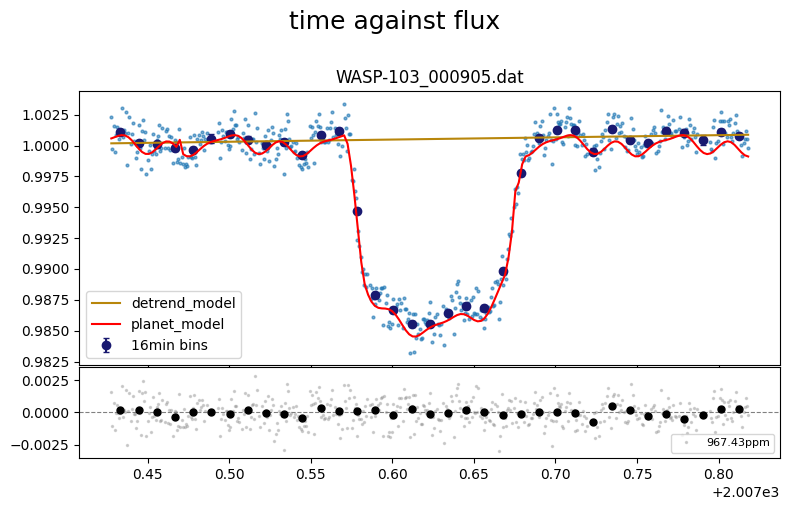

In [18]:
result.lc.plot_bestfit();

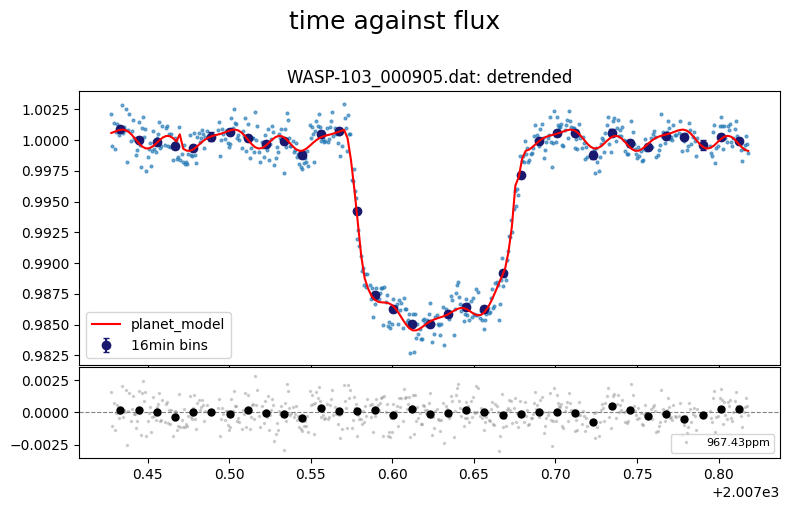

In [19]:
result.lc.plot_bestfit(detrend=True);